In [1]:
import numpy as np
import pandas as pd
from pandas import Series


In [2]:
# loading in data
weeks = []
for i in range(8):
    weeks.append(pd.read_csv('/Users/alexchoi/Downloads/nfl-big-data-bowl-2023/week' + str(i + 1) + '.csv'))
tracking = pd.concat(weeks)

In [259]:
players_data = pd.read_csv('/Users/alexchoi/Downloads/nfl-big-data-bowl-2023/players.csv')
scouting_data = pd.read_csv('/Users/alexchoi/Downloads/nfl-big-data-bowl-2023/pffScoutingData.csv')

#initializes the elo_dict
elo_dict = {}
for index, player in players_data.iterrows():
    elo_dict[player["nflId"]] = {"elo" : 1000, 
    "position": player["officialPosition"], 
    "displayName": player["displayName"], 
    "snaps": 0}

#calculates and updates the elo
def calculateElo(offense,  play):

    #goes through all the blockers and creates dict of who is being blocked
    blockedPlayers = {}
    for index, row in offense.iterrows():
        blockedPlayer = row['pff_nflIdBlockedPlayer']
        if blockedPlayer not in blockedPlayers:
            blockedPlayers[blockedPlayer] = [row['nflId']]
        else:
            blockedPlayers[blockedPlayer] += [row['nflId']]

    #iterates thought every blocked player
    for blockedPlayer in blockedPlayers.keys():
        player = play[play['nflId'] == blockedPlayer]
        numBlockers = len(blockedPlayers[blockedPlayer])
        blockerElo = 0

        #cumulates the total elo of blockers against defender
        for blockerId in blockedPlayers[blockedPlayer]:
            elo_dict[blockerId]["snaps"] += 1
            if numBlockers > 1:
                blockerElo += elo_dict[blockerId]["elo"] * numBlockers
            else:
                blockerElo = elo_dict[blockerId]["elo"]


        if blockedPlayer not in elo_dict.keys():
            elo_dict[blockedPlayer] = {"elo" : 1000, "position": "N/A", "snaps": 1, "displayName": "N/A"}
        else:
            elo_dict[blockedPlayer]["snaps"] = elo_dict[blockedPlayer]["snaps"] + 1


        #calculates expected score
        blockedPlayerExpected = 1 / (1 + pow(10, ((blockerElo - elo_dict[blockedPlayer]["elo"]) / 400)))
        blockingPlayerExpected = 1 / (1 + pow(10, ((elo_dict[blockedPlayer]["elo"] - blockerElo) / 400)))

        #cases and updates elo dictionary
        if (player['pff_sack'] == 1.0).all():
            elo_dict[blockedPlayer]["elo"] = elo_dict[blockedPlayer]["elo"] + (40 * (1 - blockedPlayerExpected) * numBlockers)
            for blockerId in blockedPlayers[blockedPlayer]:
                elo_dict[blockerId]["elo"] = elo_dict[blockerId]["elo"] + 40 * (0 - blockingPlayerExpected) 
            
            if blockedPlayer == 47785:
                print("watt")

        elif (player['pff_hit'] == 1.0).all():
            elo_dict[blockedPlayer]["elo"] = elo_dict[blockedPlayer]["elo"] + (40 * (0.8 - blockedPlayerExpected) * numBlockers)
            for blockerId in blockedPlayers[blockedPlayer]:
                elo_dict[blockerId]["elo"] = elo_dict[blockerId]["elo"] + 40 * (0.2 - blockingPlayerExpected) 

        elif (player['pff_hurry'] == 1.0).all():
            elo_dict[blockedPlayer]["elo"] = elo_dict[blockedPlayer]["elo"] + (40 * (0.75- blockedPlayerExpected) * numBlockers)
            for blockerId in blockedPlayers[blockedPlayer]:
                elo_dict[blockerId]["elo"] = elo_dict[blockerId]["elo"] + 40 * (0.25 - blockingPlayerExpected) 

        else:
            elo_dict[blockedPlayer]["elo"] = elo_dict[blockedPlayer]["elo"] + (40 * (0.1 - blockedPlayerExpected) * numBlockers)
            for blockerId in blockedPlayers[blockedPlayer]:
                elo_dict[blockerId]["elo"] = elo_dict[blockerId]["elo"] + 40 * (0.9 - blockingPlayerExpected)

        
#filters game id's
gameIds = np.array(scouting_data['gameId'])
gameIds = np.unique(gameIds)

for gameId in gameIds:
    game = scouting_data[scouting_data['gameId'] == gameId]

    #filters play id's
    playIds = np.array(game['playId'])
    playIds = np.unique(playIds)
    for playId in playIds:
        play = game[game['playId'] == playId]
        #gets the offensive and defensive players
        Offense = play[play['pff_role'] == "Pass Block"]
        calculateElo(Offense, play)



watt
watt
watt
watt
watt
watt
watt


In [257]:
p = players_data[players_data['displayName'] == "Nick Bosa"]
print(p)

     nflId height  weight   birthDate collegeName officialPosition displayName
988  47785    6-4     266  1997-10-23  Ohio State               DE   Nick Bosa


In [258]:
tj = scouting_data[scouting_data['nflId'] == 47785]
for index, row in tj.iterrows():
     if (row['pff_sack'] == 1.0):
         print("sack")


sack
sack
sack
sack
sack
sack
sack


In [266]:
# Filters to get the n best players WITH position

filtered_data = {k: v for k, v in elo_dict.items() if v["position"] == "T" and v["snaps"] > 10}
n = 10  # number of keys to get
sorted_keys = sorted(filtered_data, key=lambda x: filtered_data[x]["elo"], reverse=True)[:n]
for key in sorted_keys:
    print(elo_dict[key]["displayName"])
    print(elo_dict[key]["position"])
    print(elo_dict[key]["elo"])
    print(elo_dict[key]["snaps"])

Tristan Wirfs
T
1236.302344871977
309
Andrew Whitworth
T
1206.2693378267666
217
Rob Havenstein
T
1203.7688051859666
249
Justin Herron
T
1184.7473879092101
175
Laremy Tunsil
T
1181.3002749832488
122
Terence Steele
T
1178.4658868105098
208
Andrew Thomas
T
1177.5201618746019
166
Braden Smith
T
1175.5478703440997
88
Jason Peters
T
1168.1824577653024
224
Joe Haeg
T
1163.9600077900786
73


In [265]:
# Filters to get the n best players regardless of position
filter_snaps = {k: v for k, v in elo_dict.items() if v["snaps"] > 100}
n = 50  # number of keys to get
sorted_keys = sorted(filter_snaps, key=lambda x: filter_snaps[x]["elo"], reverse=True)[:n]
for key in sorted_keys:
    print(elo_dict[key]["displayName"])
    print(elo_dict[key]["position"])
    print(elo_dict[key]["elo"])
    print(elo_dict[key]["snaps"])

Kenny Clark
NT
1398.7582905701702
238
Aaron Donald
DT
1389.5017561141276
244
Greg Gaines
NT
1257.99074889111
118
Leonard Williams
DT
1246.6586111323847
233
Tristan Wirfs
T
1236.302344871977
309
Solomon Thomas
DT
1215.1532000289315
126
Andrew Whitworth
T
1206.2693378267666
217
Javon Hargrave
DT
1204.727306828619
172
Rob Havenstein
T
1203.7688051859666
249
Star Lotulelei
DT
1202.3385117909438
108
Josh Jones
G
1190.097745327045
228
Justin Herron
T
1184.7473879092101
175
Laremy Tunsil
T
1181.3002749832488
122
Christian Barmore
DT
1178.9292438897771
182
Terence Steele
T
1178.4658868105098
208
Oday Aboushi
G
1178.4217442663885
167
B.J. Hill
DT
1177.6335047366206
135
Andrew Thomas
T
1177.5201618746019
166
Jeffery Simmons
DT
1168.2961217514105
266
Jason Peters
T
1168.1824577653024
224
Dexter Lawrence
DE
1166.8763928336991
173
Osa Odighizuwa
DT
1164.2739368949854
171
Dion Dawkins
T
1161.9390910678032
252
Dan Moore
T
1161.018504147437
230
Zack Martin
G
1158.7503472736325
208
Brandon Scherff
G
11

(0.0, 30.0)

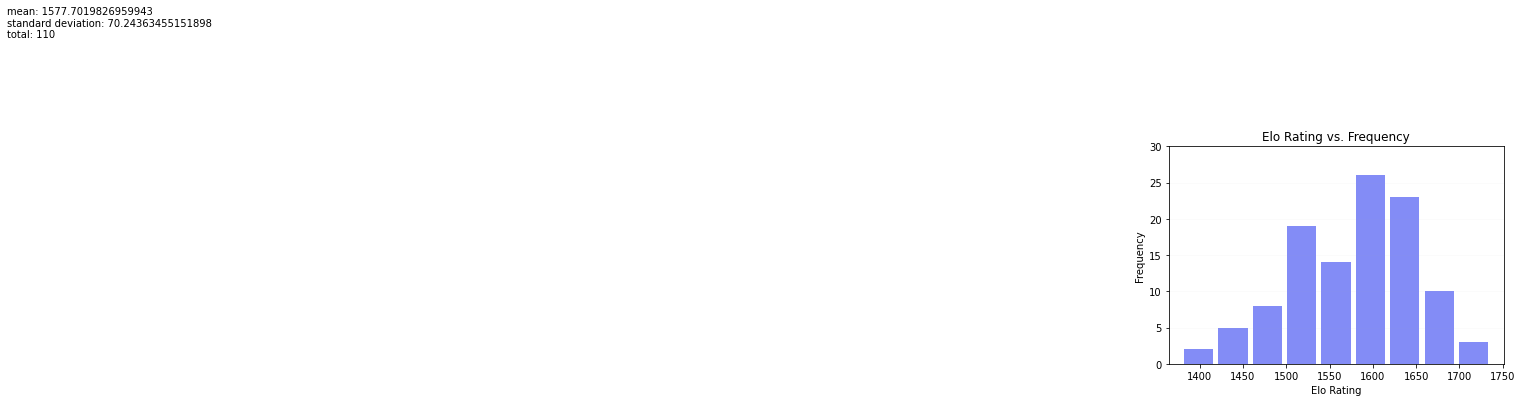

In [244]:
import matplotlib.pyplot as plt

d = []
num = 0
filtered_data = {k: v for k, v in elo_dict.items() if v["position"] == "T" and v["snaps"] > 10}
n = 10000  # number of keys to get
sorted_keys = sorted(filtered_data, key=lambda x: filtered_data[x]["elo"], reverse=True)[:n]
for key in sorted_keys:
    d.append(elo_dict[key]["elo"])
    num += 1
mean = np.mean(d)
std = np.std(d)
    
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=d, bins='auto', color='#7680f5',
                            alpha=0.9, rwidth=0.85)
plt.grid(axis='y', alpha=0.05)
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.title('Elo Rating vs. Frequency')
plt.text(23, 45, "mean: " + str(mean) + "\nstandard deviation: " + str(std) + "\ntotal: " + str(num))
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [205]:
# visualizes a single play
# source: https://www.kaggle.com/code/ammarnassanalhajali/nfl-big-data-bowl-2021-animating-players/notebook
import plotly.express as px
def visualize_play(gameId, playId):
    play = tracking.loc[(tracking['gameId'] == gameId) & 
                  (tracking['playId'] == playId)] 
    fig = px.scatter(play, x="x", y="y", animation_frame="time",
               range_x=[-10,110], range_y=[-10,53.3], 
               color='team')
    fig.update_traces(marker={'size': 9})

    fig.update_layout(paper_bgcolor='#29a500', plot_bgcolor='#29a500', font_color='white',
            width = 800,
            height = 600,
            title = "",

            xaxis = dict(
            nticks = 10,
            title = "",
            visible=False
            ),

            yaxis = dict(
            scaleanchor = "x",
            title = "Temp",
            visible=False
            ),
            showlegend= True,
                      annotations=[
           dict(
                x=-5,
                y=12,
                xref="x",
                yref="y",
                text="HOME ENDZONE",
                font=dict(size=16,color="#e9ece7"),
                align='center',
                showarrow=False,
                yanchor='bottom',
                textangle=-90
            ),
            dict(
                x=105,
                y=10,
                xref="x",
                yref="y",
                text="VISITOR ENDZONE",
                font=dict(size=16,color="#e9ece7"),
                align='center',
                showarrow=False,
                yanchor='bottom',
                textangle=90
            )]  
            ,
            legend=dict(
            traceorder="normal",
            font=dict(family="sans-serif",size=12),
            title = "",
            orientation="h",
            yanchor="bottom",
            y=1.00,
            xanchor="center",
            x=0.5
            ),
        )

    fig.add_shape(type="rect", x0=-10, x1=0,  y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#217b00" ,layer="below")
    fig.add_shape(type="rect", x0=100, x1=110, y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#217b00" ,layer="below")
    for x in range(0, 100, 10):
        fig.add_shape(type="rect", x0=x,   x1=x+10, y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#29a500" ,layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=1, x1=x, y1=2,line=dict(color="#c8ddc0",width=2),layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=51.3, x1=x, y1=52.3,line=dict(color="#c8ddc0",width=2),layer="below")

    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=20.0, x1=x, y1=21,line=dict(color="#c8ddc0",width=2),layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=32.3, x1=x, y1=33.3,line=dict(color="#c8ddc0",width=2),layer="below")

    fig.show()

ModuleNotFoundError: No module named 'plotly'

In [206]:
visualize_play(2021090900, 1078)

NameError: name 'visualize_play' is not defined